### Size

The size effect has been documented in history. The hypothesis is simple - small caps outperform large caps. Therefore, we expect to see an index-wide, averaged relationship that size factors like `market cap` are predictive of future returns.

We test this hypothesis. Recent academic literature generally states that the size factor is insignifcant for some markets.

In [3]:
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import os
from cycler import cycler

plt.style.use("dark_background")

load_dotenv('../.env')

db_url = os.getenv('DB_URL')
psql = create_engine(db_url)

We keep things simple, and use `market cap` as our size factor.

In [4]:
# market cap
size_factor = pd.read_sql(
    """
    select * from eom_factors
    where factor = 'marketcap'
    """,
    psql
)

# monthly pricing data
price_data = pd.read_sql(
    """
    select * from eom_prices
    """,
    psql
)

# get required returns data
price_data = price_data.sort_values(['ticker', 'date'])
price_data['return'] = price_data.groupby('ticker')['price'].transform(lambda x: x.pct_change())
price_data['t_plus_3_return'] = price_data.groupby('ticker')['price'].transform(lambda x: x.shift(-3) / x - 1)

# constituent data for our russell 1000 proxy
monthly_constituents = pd.read_sql(
    """
    select * from monthly_constituents
    """,
    psql
)

In [ ]:
# change to a wide format
wide_size_factor = size_factor.pivot_table(
    index = ['date', 'ticker'],
    columns = 'factor',
    values = 'value'
).reset_index()

size_data = price_data.merge(wide_size_factor, how='left', on=['date', 'ticker']).dropna()
size_data = size_data.merge(monthly_constituents, how='left', on=['date', 'ticker']).dropna()
size_data['date'] = pd.to_datetime(size_data['date'])

We normalise for interpretability purposes. Note we invert the factor, as smaller caps are expected to outperform larger caps.

In [16]:
from scipy.stats import zscore
from scipy.stats.mstats import winsorize

size_data['marketcap'] = -size_data.groupby('date')['marketcap'].transform(zscore)

We again consider the cross-sectional rank IC of the size factor.

In [23]:
cross_sectional_size_ic = []

for date, data_on_date in size_data.groupby('date'):
    cross_sectional_size_ic.append({
        'date': date,
        'rank_ic': data_on_date['marketcap'].corr(
            data_on_date['t_plus_3_return'], 
            method='spearman'
        )
    })

cross_sectional_ic_df = pd.DataFrame(cross_sectional_size_ic)
cross_sectional_ic_df = cross_sectional_ic_df.sort_values('date')
cross_sectional_ic_df['rolling_rank_ic'] = cross_sectional_ic_df['rank_ic'].rolling(window=60).mean()
cross_sectional_ic_df = cross_sectional_ic_df.dropna()

Text(0, 0.5, 'Cross-sectional rank IC (5-year rolling mean)')

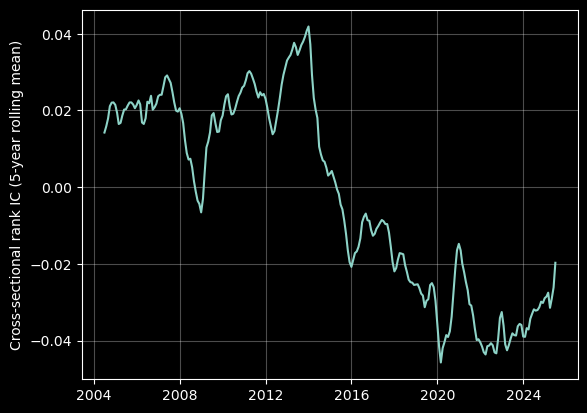

In [27]:
plt.plot(cross_sectional_ic_df['date'], cross_sectional_ic_df['rolling_rank_ic'])
plt.grid(alpha=0.3)
plt.ylabel('Cross-sectional rank IC (5-year rolling mean)')

So the size effect seems to have disappeared post-2014.